In [12]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline


def badrate(fact, predict):
    fact = list(fact)
    if len(fact) != len(predict):
        print('Параметры должны иметь одинаковую размерность')
        return
    result = {}
    for i in range(0, 10):        
        result[i] = [0, 0, 0, 0]
    for i in range(0, len(predict)):
        number = int(predict[i]*10 // 1)
        result[number][0] += 1
        result[number][1] += fact[i] 
    for i in range(10):
        result[i][2] = result[i][0] / len(predict)
        result[i][3] = result[i][1] / result[i][0]
    return result

def badrate_show(br):
    print('диапазон прогноза| доля значений | просрочка' )
    for key in br:
        print(f'{key/10}-{(key + 1)/10}          {round(br[key][2] * 100, 2)}%          {round(br[key][3] * 100, 2)}%')


In [2]:
with open('final_model_01_20230909.pkl', 'rb') as f:
    final_model = pickle.load(f)

In [5]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def metrics(fact, pred, trash=0.5):
    plot_confusion_matrix(confusion_matrix(fact, pred > trash), ['0','1'])
    print('precision:', precision_score(fact, pred > trash))
    print('recall:', recall_score(fact, pred > trash))
    print('f1_score:', f1_score(fact, pred > trash))    
    print('roc_auc:', roc_auc_score(fact, pred))
    
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df


In [6]:
def read_data(path):
    
    
    df = pd.DataFrame()

    for filename in os.listdir(path):
        full_name = path + '/' + filename
        current_df = pd.read_parquet(full_name)    
        df = pd.concat([df, current_df])
        print(full_name, 'обработан')        
    
    df.set_index('id', inplace=True)
    df = reduce_mem_usage(df)
    
    
    if 'pre_loans_total_overdue' in df.columns:
        df.drop('pre_loans_total_overdue', axis=1, inplace=True)
    
    return df
    
def transform_data(df, right_columns):
    # Строим списки переменных разного типа
    bin_features = []
    bool_features = []
    enc_features = []

    for col in df.columns:
        if df[col].nunique() == 2:
            bool_features.append(col)
        elif col.startswith('enc_'):
            enc_features.append(col)
        elif col.startswith('pre_'):
            bin_features.append(col)

    bool_features.insert(0, 'rn')
    bin_features.insert(0, 'rn')
    enc_features.insert(0, 'rn')    

    # обрабатываем разные типы переменных    
    bool_processed = bool_processing(df[bool_features])
    bin_processed = bin_processing(df[bin_features])
    enc_processed = enc_processing(df[enc_features])

    # соединяем все в один датафрейм
    df = pd.concat([bool_processed, bin_processed, enc_processed], axis = 1)

    # удаляем лишние столбцы
    drop_columns = []
    current_columns = list(df.columns)
    for cl in current_columns:
        if cl not in final_model['columns']:
            drop_columns.append(cl)        

    if len(drop_columns) > 0:
        df.drop(drop_columns, axis=1, inplace=True)

    # добавляем недостающие столбцы  нулевыми значениями
    create_columns = []
    for cl in right_columns:
        if cl not in current_columns:
            create_columns.append(cl)

    if len(create_columns) > 0:
        zeros = pd.DataFrame(0, index=df.index, columns=create_columns)
        df = pd.concat([df, zeros], axis = 1)
    
    return df
    
    
def bool_processing(bool_df):    
    bool_df.reset_index(inplace=True)     
    # формируем таблицу со значениями последних взятых кредитов для каждого id
    bool_last = bool_df.loc[bool_df.groupby('id')['rn'].idxmax()]
    bool_last.set_index('id', inplace=True)


    # формируем сводную таблицу, строки - id, столбцы - для каждого бинарного признака mun, max, sum
    columns = list(bool_df.columns)
    columns.remove('id')
    pv = bool_df.pivot_table(index=['id'], 
                             values=columns, 
                             aggfunc=[np.min, np.max, np.sum,]
                            )

    # переименовываем столбцы
    pv.columns = [t[1] + '_' + t[0] for t in pv.columns]

    # удаляем мин и макс для номера заявки в истории
    pv.drop(['rn_amin', 'rn_sum'], axis=1, inplace=True)

    # делим значения сумм признаков на количество заявок в истории (оно в признаке rn_amax),
    # что бы получить долю
    for col in pv.columns:
        if col.endswith('_sum'):
            pv[col] = pv[col]/pv['rn_amax']

    # сохраняем результаты

    bool_processed = pd.concat([pv, bool_last], axis=1)
    bool_processed.drop('rn_amax', axis=1, inplace=True)
    return bool_processed



def bin_processing(bin_df):
    bin_df.reset_index(inplace=True)
    bin_last = bin_df.loc[bin_df.groupby('id')['rn'].idxmax()]
    bin_last.set_index('id', inplace=True)
    bin_last.drop('rn', axis=1, inplace=True)

    bin_last = bin_last.astype(str)
    bin_last = pd.get_dummies(bin_last, drop_first= True)
    
    pv_rn = bin_df.pivot_table(index=['id'], 
                         values=['rn'], 
                         aggfunc=['count']
                        )
    pv_rn.columns = [t[1] + '_' + t[0] for t in pv_rn.columns]

    # создаем DataFrame для сохранения результатов
    bin_full_df = pd.DataFrame()

    # готовим список столбцов для обрабоки
    columns = list(bin_df.columns)
    columns.remove('id')
    columns.remove('rn')

    # для каждого столбца из списка создаем количество столбцов по количеству его уникальных значений 
    # и считаем количество появления этого уникального значения в истории по каждой заявке
    # все сохраняем в  bin_full_df 
    for cl in columns:
        cv = bin_df.groupby(['id', cl]). size().reset_index(name='count')

        pv = cv.pivot_table(index=['id'],
                                columns=[cl],
                                values=['count'],
                                aggfunc='sum',
                                fill_value = 0
                                )

        pv.columns = [str(t[1]) + '_' + cl for t in pv.columns]
        bin_full_df = pd.concat([bin_full_df, pv], axis = 1)

    # добавляем столбец с количеством кредитов в истории по каждой заявке
    bin_full_df = pd.concat([bin_full_df, pv_rn], axis = 1)

    # преобразовываем количество вхождения признака в долю - делим на количество кредитов в истории
    columns = list(bin_full_df.columns)
    columns.remove('rn_count')
    for cl in columns:
        bin_full_df[cl] = bin_full_df[cl]/bin_full_df['rn_count']

    # удяляем столбец с количеством кредитов в истории по каждой заявке, 
    # это значение попадет в итоговый датасет из датасета с бинарными признаками
    bin_full_df.drop('rn_count', axis=1, inplace=True)

    bin_processed = pd.concat([bin_full_df, bin_last], axis=1)
    return bin_processed


def enc_processing(enc_df):
    enc_df.reset_index(inplace=True)
    enc_last = enc_df.loc[enc_df.groupby('id')['rn'].idxmax()]
    enc_last.set_index('id', inplace=True)
    enc_last.drop('rn', axis=1, inplace=True)

    enc_last = enc_last.astype(str)
    enc_last = pd.get_dummies(enc_last, drop_first= True)

    # для каждой заявки определяем количество кредитов в истории
    pv_rn = enc_df.pivot_table(index=['id'], 
                             values=['rn'], 
                             aggfunc=['count']
                            )
    pv_rn.columns = [t[1] + '_' + t[0] for t in pv_rn.columns]

    # создаем DataFrame для сохранения результатов
    enc_full_df = pd.DataFrame()

    # готовим список столбцов для обрабоки
    columns = list(enc_df.columns)
    columns.remove('id')
    columns.remove('rn')

    # для каждого столбца из списка создаем количество столбцов по количеству его уникальных значений 
    # и считаем количество появления этого уникального значения в истории по каждой заявке
    # все сохраняем в  enc_full_df 
    for cl in columns:
        cv = enc_df.groupby(['id', cl]). size().reset_index(name='count')

        pv = cv.pivot_table(index=['id'],
                                columns=[cl],
                                values=['count'],
                                aggfunc='sum',
                                fill_value = 0
                                )

        pv.columns = [str(t[1]) + '_' + cl for t in pv.columns]
        enc_full_df = pd.concat([enc_full_df, pv], axis = 1)


    # добавляем столбец с количеством кредитов в истории по каждой заявке
    enc_full_df = pd.concat([enc_full_df, pv_rn], axis = 1)

    # преобразовываем количество вхождения признака в долю - делим на количество кредитов в истории
    columns = list(enc_full_df.columns)
    columns.remove('rn_count')
    for cl in columns:
        enc_full_df[cl] = enc_full_df[cl]/enc_full_df['rn_count']

    # удяляем столбец с количеством кредитов в истории по каждой заявке, 
    # это значение попадет в итоговый датасет из датасета с бинарными признаками
    enc_full_df.drop('rn_count', axis=1, inplace=True)
    
    enc_processed = pd.concat([enc_full_df, enc_last], axis=1)
    
    return enc_processed

In [8]:
%%time
data = read_data('train_data')
target = pd.read_csv('train_target.csv', index_col='id')

y_train, y_test = train_test_split(target, train_size=0.7, stratify=target, random_state = 42)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
x_train = data[data.index.isin(y_train.index)].copy()
x_test = data[data.index.isin(y_test.index)].copy()

train_data/train_data_0.pq обработан
train_data/train_data_1.pq обработан
train_data/train_data_10.pq обработан
train_data/train_data_11.pq обработан
train_data/train_data_2.pq обработан
train_data/train_data_3.pq обработан
train_data/train_data_4.pq обработан
train_data/train_data_5.pq обработан
train_data/train_data_6.pq обработан
train_data/train_data_7.pq обработан
train_data/train_data_8.pq обработан
train_data/train_data_9.pq обработан
Mem. usage decreased to 1696.65 Mb (86.1% reduction)
Wall time: 4min 11s


In [10]:
data_transformer = FunctionTransformer(func=transform_data, 
                                       kw_args={'right_columns': final_model['columns']}
                                      )
model = final_model['model']
scoring_pipeline = make_pipeline(data_transformer, model)

Обучаем pipeline на train
0:	learn: 0.6871174	total: 63ms	remaining: 48.2s
1:	learn: 0.6817475	total: 120ms	remaining: 46s
2:	learn: 0.6770276	total: 176ms	remaining: 44.8s
3:	learn: 0.6729551	total: 229ms	remaining: 43.5s
4:	learn: 0.6691264	total: 288ms	remaining: 43.9s
5:	learn: 0.6654578	total: 344ms	remaining: 43.6s
6:	learn: 0.6623724	total: 394ms	remaining: 42.8s
7:	learn: 0.6595786	total: 445ms	remaining: 42.2s
8:	learn: 0.6567235	total: 496ms	remaining: 41.7s
9:	learn: 0.6541142	total: 553ms	remaining: 41.8s
10:	learn: 0.6516689	total: 606ms	remaining: 41.6s
11:	learn: 0.6493760	total: 669ms	remaining: 42s
12:	learn: 0.6470635	total: 725ms	remaining: 42s
13:	learn: 0.6449576	total: 784ms	remaining: 42.1s
14:	learn: 0.6430499	total: 837ms	remaining: 41.9s
15:	learn: 0.6411887	total: 895ms	remaining: 41.9s
16:	learn: 0.6392987	total: 943ms	remaining: 41.5s
17:	learn: 0.6376484	total: 999ms	remaining: 41.5s
18:	learn: 0.6362504	total: 1.05s	remaining: 41.3s
19:	learn: 0.6348701	t

164:	learn: 0.5937143	total: 8.51s	remaining: 31s
165:	learn: 0.5936487	total: 8.56s	remaining: 31s
166:	learn: 0.5935872	total: 8.62s	remaining: 30.9s
167:	learn: 0.5935021	total: 8.67s	remaining: 30.9s
168:	learn: 0.5934430	total: 8.73s	remaining: 30.8s
169:	learn: 0.5933830	total: 8.78s	remaining: 30.8s
170:	learn: 0.5932970	total: 8.84s	remaining: 30.8s
171:	learn: 0.5932433	total: 8.89s	remaining: 30.7s
172:	learn: 0.5931299	total: 8.94s	remaining: 30.6s
173:	learn: 0.5930800	total: 8.98s	remaining: 30.6s
174:	learn: 0.5930093	total: 9.04s	remaining: 30.5s
175:	learn: 0.5929568	total: 9.09s	remaining: 30.5s
176:	learn: 0.5928804	total: 9.15s	remaining: 30.4s
177:	learn: 0.5928201	total: 9.19s	remaining: 30.4s
178:	learn: 0.5927496	total: 9.25s	remaining: 30.3s
179:	learn: 0.5926827	total: 9.3s	remaining: 30.3s
180:	learn: 0.5926349	total: 9.35s	remaining: 30.2s
181:	learn: 0.5925562	total: 9.39s	remaining: 30.1s
182:	learn: 0.5925095	total: 9.44s	remaining: 30.1s
183:	learn: 0.592

325:	learn: 0.5860299	total: 16.7s	remaining: 22.6s
326:	learn: 0.5860004	total: 16.8s	remaining: 22.5s
327:	learn: 0.5859616	total: 16.8s	remaining: 22.5s
328:	learn: 0.5859024	total: 16.9s	remaining: 22.4s
329:	learn: 0.5858783	total: 16.9s	remaining: 22.4s
330:	learn: 0.5858576	total: 17s	remaining: 22.3s
331:	learn: 0.5858113	total: 17s	remaining: 22.3s
332:	learn: 0.5857827	total: 17.1s	remaining: 22.2s
333:	learn: 0.5857543	total: 17.1s	remaining: 22.2s
334:	learn: 0.5857241	total: 17.2s	remaining: 22.1s
335:	learn: 0.5857019	total: 17.2s	remaining: 22s
336:	learn: 0.5856654	total: 17.3s	remaining: 22s
337:	learn: 0.5856399	total: 17.3s	remaining: 21.9s
338:	learn: 0.5856067	total: 17.4s	remaining: 21.9s
339:	learn: 0.5855732	total: 17.4s	remaining: 21.8s
340:	learn: 0.5855495	total: 17.5s	remaining: 21.8s
341:	learn: 0.5855226	total: 17.5s	remaining: 21.7s
342:	learn: 0.5854916	total: 17.6s	remaining: 21.7s
343:	learn: 0.5854578	total: 17.6s	remaining: 21.6s
344:	learn: 0.585411

488:	learn: 0.5817237	total: 25s	remaining: 14.1s
489:	learn: 0.5817062	total: 25s	remaining: 14.1s
490:	learn: 0.5816918	total: 25.1s	remaining: 14s
491:	learn: 0.5816712	total: 25.1s	remaining: 14s
492:	learn: 0.5816550	total: 25.2s	remaining: 13.9s
493:	learn: 0.5816378	total: 25.2s	remaining: 13.9s
494:	learn: 0.5816193	total: 25.3s	remaining: 13.8s
495:	learn: 0.5816018	total: 25.3s	remaining: 13.8s
496:	learn: 0.5815808	total: 25.3s	remaining: 13.7s
497:	learn: 0.5815680	total: 25.4s	remaining: 13.7s
498:	learn: 0.5815551	total: 25.4s	remaining: 13.6s
499:	learn: 0.5815350	total: 25.5s	remaining: 13.6s
500:	learn: 0.5815218	total: 25.5s	remaining: 13.5s
501:	learn: 0.5814927	total: 25.6s	remaining: 13.5s
502:	learn: 0.5814700	total: 25.6s	remaining: 13.4s
503:	learn: 0.5814594	total: 25.7s	remaining: 13.4s
504:	learn: 0.5814417	total: 25.7s	remaining: 13.3s
505:	learn: 0.5814162	total: 25.8s	remaining: 13.3s
506:	learn: 0.5813943	total: 25.8s	remaining: 13.2s
507:	learn: 0.581379

647:	learn: 0.5787340	total: 33s	remaining: 6.01s
648:	learn: 0.5787183	total: 33.1s	remaining: 5.97s
649:	learn: 0.5787026	total: 33.1s	remaining: 5.91s
650:	learn: 0.5786904	total: 33.2s	remaining: 5.86s
651:	learn: 0.5786720	total: 33.2s	remaining: 5.81s
652:	learn: 0.5786552	total: 33.3s	remaining: 5.76s
653:	learn: 0.5786394	total: 33.3s	remaining: 5.71s
654:	learn: 0.5786227	total: 33.4s	remaining: 5.66s
655:	learn: 0.5786058	total: 33.4s	remaining: 5.61s
656:	learn: 0.5785860	total: 33.5s	remaining: 5.56s
657:	learn: 0.5785722	total: 33.5s	remaining: 5.5s
658:	learn: 0.5785511	total: 33.6s	remaining: 5.45s
659:	learn: 0.5785333	total: 33.6s	remaining: 5.4s
660:	learn: 0.5785111	total: 33.7s	remaining: 5.35s
661:	learn: 0.5784935	total: 33.7s	remaining: 5.3s
662:	learn: 0.5784736	total: 33.8s	remaining: 5.25s
663:	learn: 0.5784607	total: 33.8s	remaining: 5.2s
664:	learn: 0.5784486	total: 33.9s	remaining: 5.15s
665:	learn: 0.5784408	total: 33.9s	remaining: 5.1s
666:	learn: 0.57842

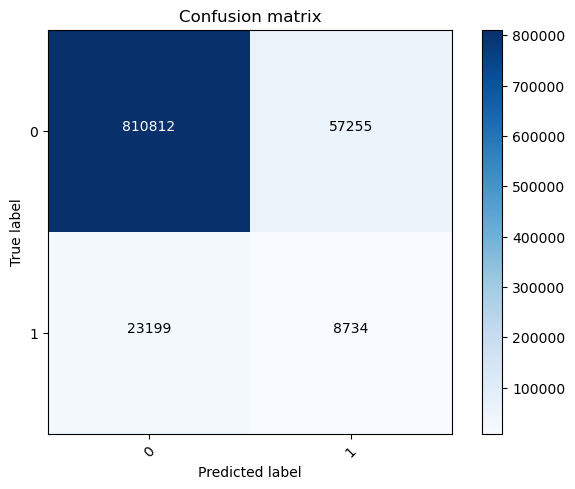

In [11]:
%%time
print('Обучаем pipeline на train')
scoring_pipeline.fit(x_train, y_train)

print('Строим прогноз на test')
test_pred = scoring_pipeline.predict_proba(x_test)[:,1]

print('Выводим метрики для test')
metrics(y_test, test_pred, trash=final_model['trash'])